In [2]:
#import dependencies

import numpy as np
from sklearn.decomposition import PCA
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
import cv2
from sklearn.neighbors import NearestNeighbors

In [3]:
def load_hsi(file_name):
    # load hyperspectral image
    _, extension = os.path.splitext(file_name)

    if extension == '.tiff':
        #below is a way to load hyperspectral images that are tiff files
        mylist = []
        loaded,mylist = cv2.imreadmulti(mats = mylist, filename = file_name, flags = cv2.IMREAD_ANYCOLOR )
        cube=np.array(mylist)
        cube = cube[:, :, :]
    else :
        print("Error: file type not supported")
        return
    return cube




class Dinov2Matcher:

  def __init__(self, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14", smaller_edge_size=448, half_precision=False, device="cuda"):
    self.repo_name = repo_name
    self.model_name = model_name
    self.smaller_edge_size = smaller_edge_size
    self.half_precision = half_precision
    self.device = device

    if self.half_precision:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).half().to(self.device)
    else:
      self.model = torch.hub.load(repo_or_dir=repo_name, model=model_name).to(self.device)

    self.model.eval()

    self.transform = transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

  # https://github.com/facebookresearch/dinov2/blob/255861375864acdd830f99fdae3d9db65623dafe/notebooks/features.ipynb
  def prepare_image(self, rgb_image_numpy):
    # image = Image.fromarray(rgb_image_numpy)

    if isinstance(rgb_image_numpy, np.ndarray):
        image = Image.fromarray(rgb_image_numpy)
    elif isinstance(rgb_image_numpy, Image.Image):
        image = rgb_image_numpy
    else:
        raise TypeError('rgb_image_numpy must be a NumPy array or a PIL Image')

    image_tensor = self.transform(image)
    resize_scale = image.width / image_tensor.shape[2]

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % self.model.patch_size, height - height % self.model.patch_size # crop a bit from right and bottom parts
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // self.model.patch_size, cropped_width // self.model.patch_size)
    return image_tensor, grid_size, resize_scale

  def prepare_mask(self, mask_image_numpy, grid_size, resize_scale):
    cropped_mask_image_numpy = mask_image_numpy[:int(grid_size[0]*self.model.patch_size*resize_scale), :int(grid_size[1]*self.model.patch_size*resize_scale)]
    image = Image.fromarray(cropped_mask_image_numpy)
    resized_mask = image.resize((grid_size[1], grid_size[0]), resample=Image.Resampling.NEAREST)
    resized_mask = np.asarray(resized_mask).flatten()
    return resized_mask

  def extract_features(self, image_tensor):
    with torch.inference_mode():
      if self.half_precision:
        image_batch = image_tensor.unsqueeze(0).half().to(self.device)
      else:
        image_batch = image_tensor.unsqueeze(0).to(self.device)

      tokens = self.model.get_intermediate_layers(image_batch)[0].squeeze()
    return tokens.cpu().numpy()

  def idx_to_source_position(self, idx, grid_size, resize_scale):
    row = (idx // grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    col = (idx % grid_size[1])*self.model.patch_size*resize_scale + self.model.patch_size / 2
    return row, col

  def get_embedding_visualization(self, tokens, grid_size, resized_mask=None):
    pca = PCA(n_components=3)
    if resized_mask is not None:
      tokens = tokens[resized_mask]
    reduced_tokens = pca.fit_transform(tokens.astype(np.float32))
    if resized_mask is not None:
      tmp_tokens = np.zeros((*resized_mask.shape, 3), dtype=reduced_tokens.dtype)
      tmp_tokens[resized_mask] = reduced_tokens
      reduced_tokens = tmp_tokens
    reduced_tokens = reduced_tokens.reshape((*grid_size, -1))
    normalized_tokens = (reduced_tokens-np.min(reduced_tokens))/(np.max(reduced_tokens)-np.min(reduced_tokens))
    return normalized_tokens


def extract_rgb(cube, red_layer=78 , green_layer=40, blue_layer=25,  visualize=False):
    red_img = cube[ red_layer,:,:]
    green_img = cube[ green_layer,:,:]
    blue_img = cube[ blue_layer,:,:]


    data=np.stack([red_img,green_img,blue_img], axis=-1)
    # print(data.shape)
    #print(type(image))

    #convert to 8bit
    x_norm = (data-np.min(data))/(np.max(data)-np.min(data))
    image=(x_norm*255).astype('uint8')
    if visualize:
        #pass
        plt.imshow(image)
        plt.show()
    return image

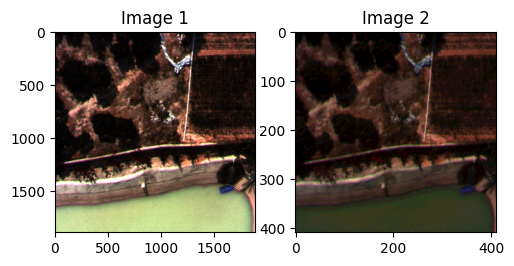

In [4]:

# gets hyperspectral image and converts to RGB
hyperImage = load_hsi('../../HyperImages/img1.tiff')
hyperImage2 = load_hsi('../../HyperImages/low_res_mlt.tiff')

hyperImage_norm = (hyperImage/255).astype('float32') # between 0 and 1
hyperImage_norm2 = (hyperImage2/255).astype('float32') # between 0 and 1

num_layers = hyperImage.shape[0]

#standard_array = load_array_from_url(STANDARD_ARRAY_URL)

example_image = extract_rgb(hyperImage)
example_image2 = extract_rgb(hyperImage2)


fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image)
plt.title('Image 1')

plt.subplot(1, 5, 2)  # 1 row, 3 columns, 1st subplot = image1
plt.imshow(example_image2)
plt.title('Image 2')

plt.show()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:06<00:00, 57.5MB/s] 


(1024, 768) (1024, 768)
Number of matches:  1024
shape (1024, 1)


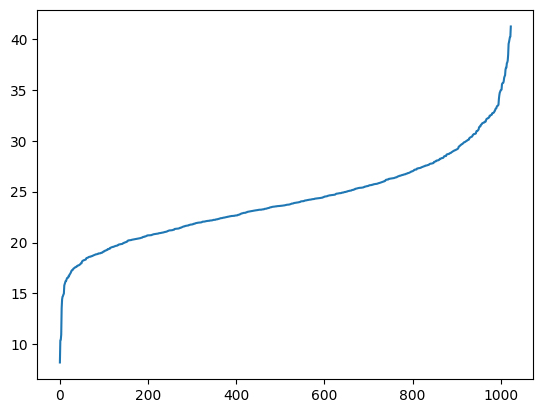

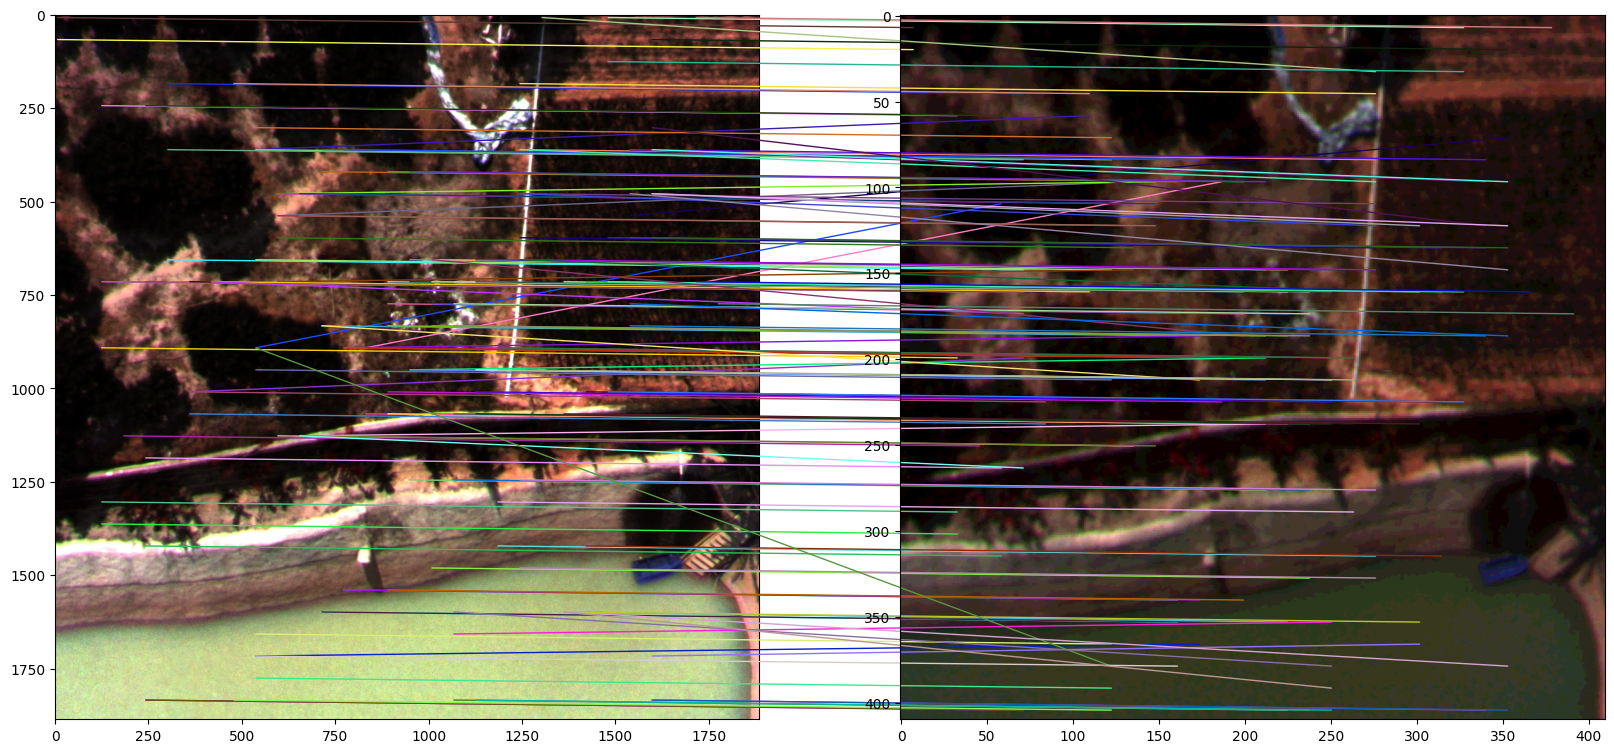

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np


dm = Dinov2Matcher(half_precision=False)



image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(example_image)
features1 = dm.extract_features(image_tensor1)

image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(example_image2)
image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(example_image2)
features2 = dm.extract_features(image_tensor2)


knn = NearestNeighbors(n_neighbors=1)
knn.fit(features1)
distances, match2to1 = knn.kneighbors(features2)
match2to1 = np.array(match2to1)

print(features1.shape,  features2.shape)

#used to help filter
plt.plot(sorted(distances))



# Define a distance threshold
threshold = 20.0


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(example_image)
ax2.imshow(example_image2)

for idx2, (dist, idx1) in enumerate(zip(distances, match2to1)):
  
  # Skip if the distance is above the threshold
  if dist > threshold:
    continue
  
  row, col = dm.idx_to_source_position(idx1, grid_size1, resize_scale1)
  xyA = (col, row)
  #if not mask1[int(row), int(col)]: continue # skip if feature is not on the object

  row, col = dm.idx_to_source_position(idx2, grid_size2, resize_scale2)
  xyB = (col, row)
  #if not mask2[int(row), int(col)]: continue # skip if feature is not on the object

  # if np.random.rand() > 0.10: continue # sparsely draw so that we can see the lines...

  con = ConnectionPatch(xyA=xyB, xyB=xyA, coordsA="data", coordsB="data",
                        axesA=ax2, axesB=ax1, color=np.random.rand(3,))
  ax2.add_artist(con)

print("Number of matches: ", len(match2to1))
print("shape" , match2to1.shape)
